In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
from statsmodels.stats.proportion import proportion_confint
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
datetime.datetime.now().date() - timedelta(days=200)

datetime.date(2018, 4, 7)

In [3]:
datetime.datetime.now().date() - timedelta(days=116)

datetime.date(2018, 6, 30)

In [4]:
datetime.datetime.now().date() - timedelta(days=116) + timedelta(days=84)

datetime.date(2018, 9, 22)

**For those IT shop customers who placed their 1st order whenever between 06/04/18 and 29/06/18 (84 days) let's get also their 2nd IT shop orders in case they took place in a window of 168 days from the first date (until 21/09/18)**

### Data loading, cleaning & formatting

In [5]:
data = pd.read_csv('nc_orders_it_84_days.dsv', sep=';', low_memory=False)

In [6]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
0,479745111,112813025,15/06/2018 00:00,01:44,12,17352072,"2,99","2,4508","2,4508","2,4508",...,1,301,"0,513",10331,"0,513",17/07/2017 22:15,17/07/2018 23:59,56.0,5.0,"4,99"
1,479745108,112813025,15/06/2018 00:00,01:44,12,17352072,"19,99","8,6452","1,584","16,3852",...,1,301,"0,513",10331,"0,513",17/07/2017 22:15,17/07/2018 23:59,56.0,5.0,"4,99"
2,479745107,112813025,15/06/2018 00:00,01:44,12,17352072,"9,99","3,6285","3,2771","8,1885",...,1,301,"0,513",10331,"0,513",17/07/2017 22:15,17/07/2018 23:59,56.0,5.0,"4,99"
3,479745109,112813025,15/06/2018 00:00,01:44,12,17352072,"8,99","2,6089","1,9076","7,3689",...,1,301,"0,513",10331,"0,513",17/07/2017 22:15,17/07/2018 23:59,56.0,5.0,"4,99"
4,479745110,112813025,15/06/2018 00:00,01:44,12,17352072,"-1,95","-1,5984","-1,5984","-1,5984",...,1,301,"0,513",10331,"0,513",17/07/2017 22:15,17/07/2018 23:59,56.0,5.0,"4,99"


In [7]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186121 entries, 0 to 186120
Data columns (total 23 columns):
SCM_N_ORDER_POS_NR              186121 non-null int64
SCM_N_ORDER_NR                  186121 non-null int64
TDT_T_KEY_ORDER_DATE            186121 non-null object
THR_C_KEY_ORDER_HOUR            186121 non-null object
SIT_N_KEY_SITE                  186121 non-null int64
CUS_N_KEY_CUSTOMER              186121 non-null int64
SCM_SALES_BMF                   186121 non-null object
SCM_D_FINANCE_CM1               186121 non-null object
SCM_D_FINANCE_CM2               186121 non-null object
SCM_D_ORIG_FINANCE_ORDER_NET    186121 non-null object
SCM_AP_ID                       186121 non-null int64
SCM_AS_ID                       186121 non-null int64
SCM_MASTER_AP_ID                186121 non-null int64
OSP_KO_COUNT_NET                186121 non-null int64
OSP_3_LEAD_P_PG_ID              186121 non-null int64
OSP_3_LEAD_P_PG_SHARE           186121 non-null object
OSP_4_LEAD_P_PG_ID

In [8]:
def get_date(x):
    return x.split(' ')[0]

In [9]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [10]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format="%d/%m/%Y")
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], format="%Y/%m/%d %H:%M:%S")
data['CZP_START_DATE'] = pd.to_datetime(data['CZP_START_DATE'], format="%d/%m/%Y %H:%M")
data['CZP_EXPIRY_DATE'] = pd.to_datetime(data['CZP_EXPIRY_DATE'], format="%d/%m/%Y %H:%M")

data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['CZP_PRICE'] = [float(str(i).replace(',','.')) for i in data['CZP_PRICE'].values]
data['OSP_3_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_3_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]

data['WEEK_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.week
data['MONTH_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.month

In [11]:
data['CZP_ZTQ_ID'] = data['CZP_ZTQ_ID'].fillna(0).astype(int)

In [12]:
#Order counter in our data, different tiers appearing in dataset...
data['OSP_KO_COUNT_NET'].unique(), data['CZP_ZTQ_ID'].unique()

(array([1, 2], dtype=int64), array([56, 55,  0], dtype=int64))

In [13]:
#Orders belonging to each tier
data.groupby('SCM_N_ORDER_NR')['CZP_ZTQ_ID'].min().value_counts()

0     49393
56     3302
55      832
Name: CZP_ZTQ_ID, dtype: int64

In [14]:
#boolean mask with duplicated orders as True
dupl_mask = [len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values]

In [15]:
#get duplicated order IDs
dup_orders = data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique()[dupl_mask].index.values

In [16]:
#NO duplicated orders
len(dup_orders), dup_orders

(0, array([], dtype=int64))

In [17]:
len(data)

186121

In [18]:
#data.to_pickle("./nc_orders_it_84_days.pkl")

In [19]:
data = pd.read_pickle("./nc_orders_it_84_days.pkl")

In [20]:
data['SCM_N_ORDER_NR'].nunique()

53527

In [21]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER'],
      dtype='object')

#### From order_position to order level

In [22]:
#Aggregation to order level
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'SCM_AP_ID': lambda x: list(x),
          'SCM_AS_ID': lambda x: list(x),
          'SCM_MASTER_AP_ID': lambda x: list(x),
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'OSP_3_LEAD_P_PG_ID': min
          }

In [23]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [24]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [25]:
orders.columns = (['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list',
       'SCM_D_FINANCE_CM1_sum', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_sum', 'SCM_AP_ID_list',
       'SCM_AS_ID_list', 'SCM_MASTER_AP_ID_list',
       'OSP_KO_COUNT_NET', 'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'OSP_3_LEAD_P_PG_ID'])

In [26]:
orders

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM2_sum,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_AP_ID_list,SCM_AS_ID_list,SCM_MASTER_AP_ID_list,OSP_KO_COUNT_NET,CZP_START_DATE,CZP_EXPIRY_DATE,OSP_3_LEAD_P_PG_ID
0,108152192,2018-04-06,19897061,0,151.97,"[59.99, 91.98]",35.0955,19.3596,124.5655,"[61044, 60996]","[1313632, 1309318]","[61044, 60996]",1,NaT,NaT,251
1,108152234,2018-04-06,19897073,0,37.97,"[4.99, 7.99, 24.99]",12.9730,5.2175,31.1230,"[76404, 32209, 26920]","[2307546, 548556, 440713]","[76404, 32209, 26920]",1,NaT,NaT,33
2,108152344,2018-04-06,19897080,0,46.78,"[25.99, 25.99, -5.2]",7.2773,0.3779,42.5273,"[69082, 68570, 0]","[2379698, 1873611, 1]","[69082, 68570, 6169]",1,NaT,NaT,207553
3,108152458,2018-04-06,19897074,0,89.95,"[6.99, 4.98, 7.99, 69.99]",27.6396,18.5679,73.7296,"[25741, 0, 42867, 66865]","[432472, 2, 2327141, 1692198]","[25741, 6168, 42867, 66865]",1,NaT,NaT,251
4,108152511,2018-04-06,19897135,0,42.72,"[7.99, 17.99, 18.99, -2.25]",9.2576,-3.2566,38.1576,"[72035, 68576, 68654, 0]","[2064769, 1894283, 2383232, 1]","[72035, 68576, 68654, 6169]",1,NaT,NaT,207553
5,108152525,2018-04-06,19897137,0,46.53,"[-2.45, 25.99, 22.99]",7.7300,0.8306,42.3000,"[0, 69082, 69083]","[1, 2383089, 2383088]","[6169, 69082, 69083]",1,NaT,NaT,207553
6,108152540,2018-04-06,19897023,56,142.25,"[33.89, 33.89, 27.99, 5.99, 19.99, 27.99, -7.49]",48.0683,25.8984,116.5983,"[73509, 73474, 66884, 42225, 65164, 66885, 0]","[2174597, 2174596, 1801728, 913725, 1569058, 1...","[73509, 73474, 66884, 42225, 65164, 66885, 42715]",1,2018-04-06,2019-04-06,251
7,108152852,2018-04-06,19897169,0,35.98,"[17.99, 17.99]",12.2118,6.0454,29.4918,"[69454, 69465]","[1902178, 1902423]","[69454, 69465]",1,NaT,NaT,251
8,108152874,2018-04-06,19897109,0,27.44,"[4.49, 7.98, 6.98, 7.99]",12.7718,5.8510,22.4918,"[61245, 71112, 0, 73434]","[1311745, 2010109, 2, 2273821]","[61245, 71112, 6168, 73434]",1,NaT,NaT,252
9,108152948,2018-04-06,19897166,0,15.97,"[13.0, 12.99, 22.99, 16.99, -50.0]",-27.4843,-40.8966,13.9557,"[68059, 67426, 69080, 70693, 0]","[2273201, 2273201, 1900515, 1964899, 1]","[68059, 68059, 69080, 70693, 6169]",1,NaT,NaT,207624


In [27]:
orders['SP_SOLD'] = [(42225 in i) * 1 for i in orders['SCM_MASTER_AP_ID_list'].values]

### Eligibility rules set up

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
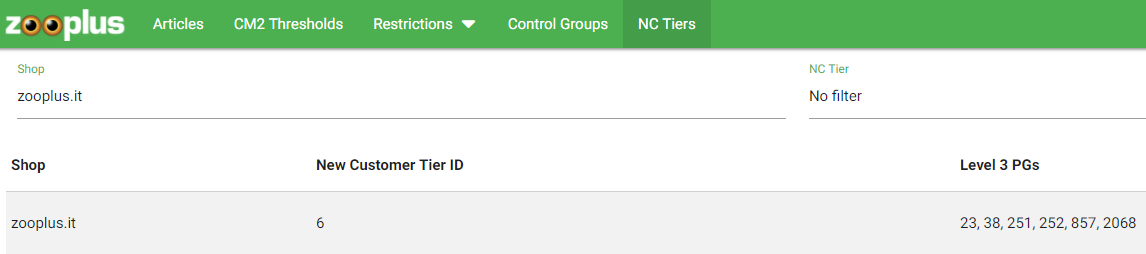

In [28]:
lead_pg3 = [23, 38, 251, 252, 857, 2068]

Based only on Lead PG3, let's re-create the eligibility rules...

In [29]:
orders.sample(5)

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM2_sum,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_AP_ID_list,SCM_AS_ID_list,SCM_MASTER_AP_ID_list,OSP_KO_COUNT_NET,CZP_START_DATE,CZP_EXPIRY_DATE,OSP_3_LEAD_P_PG_ID,SP_SOLD
26866,111539596,2018-05-28,20323168,0,52.97,"[31.99, 16.99, 3.99]",12.0680,5.1880,43.4180,"[63156, 23387, 64072]","[1441999, 2067396, 1565454]","[63156, 23387, 64072]",1,NaT,NaT,251,0
26693,111514418,2018-05-28,20217369,0,51.08,"[27.58, 26.4, 1.29, -5.68, 1.49]",18.3889,-0.2759,41.8689,"[33229, 33327, 23976, 0, 23968]","[2320252, 2320252, 353121, 1, 353122]","[33229, 33229, 23976, 6169, 23968]",2,NaT,NaT,301,0
53329,119155863,2018-09-17,20195286,0,49.99,[49.99],13.3854,6.4216,40.9754,[58576],[1190246],[58576],2,NaT,NaT,251,0
9348,109343441,2018-04-24,19996641,0,109.99,[109.99],23.0757,16.8261,90.1557,[74784],[2192388],[74784],2,NaT,NaT,409,0
29942,111914282,2018-06-02,20368939,0,35.93,"[4.99, 5.49, 3.99, 1.99, 5.99, 10.99, 2.49]",16.0608,6.6898,29.4508,"[33641, 22185, 51819, 58428, 64305, 73458, 52835]","[562828, 330207, 991581, 1253482, 1604020, 218...","[33641, 22185, 51819, 58428, 64305, 73458, 52835]",1,NaT,NaT,301,0


In [30]:
orders['O_ELIG'] = (orders['OSP_3_LEAD_P_PG_ID'].isin(lead_pg3)) * 1

In [31]:
orders.groupby(['OSP_KO_COUNT_NET', 'CZP_ZTQ_ID'], as_index=False)['SP_SOLD'].sum()

,OSP_KO_COUNT_NET,CZP_ZTQ_ID,SP_SOLD
0,1,0,2
1,1,55,376
2,1,56,1482
3,2,0,0
4,2,55,194
5,2,56,741


In [32]:
orders.groupby('OSP_KO_COUNT_NET')['O_ELIG'].value_counts()

OSP_KO_COUNT_NET  O_ELIG
1                 1         19842
                  0         18762
2                 1         10209
                  0          4714
Name: O_ELIG, dtype: int64

In [34]:
# Facts facing inference:
# - We assume that interest in acquire SP from current non-eligible customers (orders) does not vary (p.e. accessories)
# - The SP variant we want to keep converts around 3-4 times less compared with tier 56. 

#### From order to customer level

In [35]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET_sum': [sum, lambda x: list(np.round(x, 2))],
              'OSP_3_LEAD_P_PG_ID': lambda x: list(x),
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'SP_SOLD': lambda x: list(x),
              'O_ELIG': lambda x: list(x)
              }

In [36]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [37]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [38]:
customers.columns

Index(['CUS_N_KEY_CUSTOMER', 'CZP_ZTQ_ID_unique', 'SCM_N_ORDER_NR_len',
       'SCM_SALES_BMF_sum_sum', 'SCM_SALES_BMF_sum_<lambda>',
       'SCM_D_FINANCE_CM1_sum_sum', 'SCM_D_FINANCE_CM1_sum_<lambda>',
       'SCM_D_FINANCE_CM2_sum_sum', 'SCM_D_FINANCE_CM2_sum_<lambda>',
       'SCM_D_ORIG_FINANCE_ORDER_NET_sum_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_sum_<lambda>',
       'OSP_3_LEAD_P_PG_ID_<lambda>', 'OSP_KO_COUNT_NET_<lambda>',
       'SP_SOLD_<lambda>', 'O_ELIG_<lambda>'],
      dtype='object')

In [39]:
customers.columns = ['CUS_N_KEY_CUSTOMER', 'CZP_ZTQ_ID_unique', 'SCM_N_ORDER_NR_len',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list',
       'SCM_D_FINANCE_CM1_sum', 'SCM_D_FINANCE_CM1_list',
       'SCM_D_FINANCE_CM2_sum', 'SCM_D_FINANCE_CM2_list',
       'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_3_LEAD_P_PG_ID_list',
       'OSP_KO_COUNT_NET_list', 'SP_SOLD_list', 'O_ELIG_list']

In [40]:
customers.sample(20)

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_D_ORIG_FINANCE_ORDER_NET_list,OSP_3_LEAD_P_PG_ID_list,OSP_KO_COUNT_NET_list,SP_SOLD_list,O_ELIG_list
28575,20408107,[0],1,65.98,[65.98],12.05,[12.05],4.82,[4.82],54.08,[54.08],[251],[1],[0],[1]
34840,20529197,[0],1,46.99,[46.99],7.72,[7.72],-1.10,[-1.1],38.52,[38.52],[251],[1],[0],[1]
26702,20370102,[0],2,135.55,"[87.41, 48.14]",62.36,"[41.19, 21.17]",27.20,"[21.32, 5.88]",117.29,"[76.12, 41.17]","[305, 252]","[1, 2]","[0, 0]","[0, 1]"
5,2076334,[0],1,8.98,[8.98],5.54,[5.54],1.32,[1.32],7.36,[7.36],[153317],[1],[0],[0]
37501,20578618,[0],1,40.98,[40.98],8.01,[8.01],1.54,[1.54],33.59,[33.59],[252],[1],[0],[1]
18220,20207335,[56],1,79.78,[79.78],17.53,[17.53],8.90,[8.9],65.39,[65.39],[251],[1],[1],[1]
2511,19921133,[0],1,28.95,[28.95],16.77,[16.77],7.99,[7.99],23.73,[23.73],[153317],[1],[0],[0]
22640,20291942,[0],1,79.99,[79.99],26.41,[26.41],16.21,[16.21],65.57,[65.57],[758],[1],[0],[0]
20477,20249932,[0],1,23.77,[23.77],8.30,[8.3],0.42,[0.42],19.48,[19.48],[301],[1],[0],[0]
15427,20156032,[0],2,149.74,"[108.75, 40.99]",28.97,"[23.91, 5.06]",5.90,"[10.09, -4.18]",122.74,"[89.14, 33.6]","[207553, 251]","[1, 2]","[0, 0]","[0, 1]"


### Workflow
    + 1st orders: % of non-eligible and eligible (from the latter ones get SP CR% in 1st order)
    + 2nd orders: get probability of repurchase when coming from a non-eligible 1st order and from an eligible one
    + Eligibility in 2nd order: 2nd order itself or inherited from the 1st one
    + Calculate SP conversion in 2nd order for the available ways

In [41]:
#Does 1st order make the customer eligible?
customers['CUS_ELIG_1ST'] = [(i[0] == 1) * 1 for i in customers['O_ELIG_list'].values]

In [42]:
#Has the customer placed a 2nd order?
customers['HAS_2ND_ORDER'] = [(len(i) > 1) * 1 for i in customers['OSP_KO_COUNT_NET_list'].values]

In [43]:
#Does 2nd order -in case the 1st one does not- make the customer eligible?
customers['CUS_ELIG_2ND'] = [(i[0] == 0 and i[1] == 1) * 1 if len(i) == 2 else 0 for i in customers['O_ELIG_list'].values]

In [44]:
#Is SP sold in 1st order?
customers['SP_SOLD_1ST'] = [(i[0] == 1) * 1 for i in customers['SP_SOLD_list'].values]

In [45]:
#Is SP sold in 2nd order?
customers['SP_SOLD_2ND'] = [(i[0] == 0 and i[1] == 1) * 1 if len(i) > 1 else 0 for i in customers['SP_SOLD_list'].values]

In [46]:
#Does the customer belong to tier 55?
customers['TIER_55'] = [(55 in i) * 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [47]:
#Does he belong to 56?
customers['TIER_56'] = [(56 in i) * 1 for i in customers['CZP_ZTQ_ID_unique'].values]

**SP CR% in 1st order:**

In [48]:
# Dividing SP sold in 1st order by every customer made eligible by his 1st order
print('SP conversion rate in 1st order: ', np.round(customers['SP_SOLD_1ST'].sum()/customers['CUS_ELIG_1ST'].sum() * 100, 2), '%')

SP conversion rate in 1st order:  9.37 %


In [49]:
print('SP 3% (tier 55) conversion rate in 1st order: ', 
      np.round((customers['SP_SOLD_1ST'] * customers['TIER_55']).sum()/customers['CUS_ELIG_1ST'].sum() * 100, 2), '%')

SP 3% (tier 55) conversion rate in 1st order:  1.9 %


In [50]:
print('SP 5% (tier 56) conversion rate in 1st order: ', 
      np.round((customers['SP_SOLD_1ST'] * customers['TIER_56']).sum()/customers['CUS_ELIG_1ST'].sum() * 100, 2), '%')

SP 5% (tier 56) conversion rate in 1st order:  7.46 %


**Probability of repurchasing if 1st order was eligible or not:**

In [54]:
rep_if_elig = customers.groupby('CUS_ELIG_1ST').agg({'CUS_ELIG_1ST': 'count',
                                                     'SP_SOLD_1ST': sum,
                                                     'HAS_2ND_ORDER': sum,
                                                     'CUS_ELIG_2ND': sum,
                                                     'SP_SOLD_2ND': sum})

In [55]:
rep_if_elig['PROB'] = np.round(rep_if_elig['HAS_2ND_ORDER'] / rep_if_elig['CUS_ELIG_1ST'], 3)

In [56]:
rep_if_elig

,CUS_ELIG_1ST,SP_SOLD_1ST,HAS_2ND_ORDER,CUS_ELIG_2ND,SP_SOLD_2ND,PROB
CUS_ELIG_1ST,,,,,,
0,18771,0,5022,1782,252,0.268
1,19855,1860,9877,0,682,0.497


In [57]:
print('Probability of repurchasing in our data without SP eligibility [between 84 and 168 days from 1st order]:' , 
      np.round(customers['HAS_2ND_ORDER'].sum() / customers['CUS_ELIG_1ST'].count(), 3))

Probability of repurchasing in our data without SP eligibility [between 84 and 168 days from 1st order]: 0.386


**SP CR% in 2nd order:**

In second order we have 2 different groups:
    + Those seeing the offer for the 1st time in 2nd order because only their 2nd order makes them eligible
    + Those who have already seen the offer and didn´t buy the SP in 1st order, and see it again during the 2nd
    
For each group we will calculate probabilities conditioned by repurchase and by tier (55 or 56)

In [59]:
#Prob of get SP in 2nd order if eligible in second
np.round(customers[customers['CUS_ELIG_2ND'] == 1]['SP_SOLD_2ND'].sum() / customers[customers['CUS_ELIG_2ND'] == 1]['SP_SOLD_2ND'].count(), 3)

0.141

Sum of the two probabilities below must be equal to the cell above:

In [78]:
#Prob of get SP tier 55 in 2nd order if eligible in second
np.round(customers[(customers['CUS_ELIG_2ND'] == 1)  & (customers['TIER_55'] == 1)]['SP_SOLD_2ND'].sum() / customers[customers['CUS_ELIG_2ND'] == 1]['SP_SOLD_2ND'].count(), 3)

0.024

In [79]:
#Prob of get SP tier 56 in 2nd order if eligible in second
np.round(customers[(customers['CUS_ELIG_2ND'] == 1)  & (customers['TIER_56'] == 1)]['SP_SOLD_2ND'].sum() / customers[customers['CUS_ELIG_2ND'] == 1]['SP_SOLD_2ND'].count(), 3)

0.118

Now involving repurchase when 1st order was not eligible...

In [67]:
#Prob of get SP in 2nd order if eligible in second * Prob of repurchase if 1st order was not eligible
np.round(0.141 * 0.268, 3)

0.038

Sum of the two probabilities below must be equal to the cell above:

In [80]:
#Prob of get SP tier 55 in 2nd order if eligible in second * Prob of repurchase if 1st order was not eligible
np.round(0.024 * 0.268, 3)

0.006

In [81]:
#Prob of get SP tier 56 in 2nd order if eligible in second * Prob of repurchase if 1st order was not eligible
np.round(0.118 * 0.268, 3)

0.032

Let's calculate now probabilities for the 2nd group, that means those already eligible in 1st order (inherited eligibility)

In [61]:
#Prob of get SP in 2nd order if already eligible in first -offer seen twice-
np.round((customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER'] * customers['SP_SOLD_2ND']).sum() /\
(customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER']).sum(), 3)

0.079

And now, split them by tier...sum of the two probabilities below must be equal to the cell above:

In [82]:
#Prob of get SP tier 55 in 2nd order if already eligible in first -offer seen twice-
np.round((customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER'] * customers['SP_SOLD_2ND'] * customers['TIER_55']).sum() /\
(customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER']).sum(), 3)

0.018

In [83]:
#Prob of get SP tier 56 in 2nd order if already eligible in first -offer seen twice-
np.round((customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER'] * customers['SP_SOLD_2ND'] * customers['TIER_56']).sum() /\
(customers['CUS_ELIG_1ST'] * (customers['SP_SOLD_1ST'] == 0) * customers['HAS_2ND_ORDER']).sum(), 3)

0.062

We add repurchase when 1st order was already eligible

In [63]:
#Prob of get SP in 2nd order if already eligible in first -offer seen twice- * Prob of repurchase if 1st order was eligible
np.round(0.079 * 0.497, 3)

0.039

Get probs per tier...

In [84]:
#Prob of get SP tier 55 in 2nd order if already eligible in first -offer seen twice- * Prob of repurchase if 1st order was eligible
np.round(0.018 * 0.497, 3)

0.009

In [85]:
#Prob of get SP tier 56 in 2nd order if already eligible in first -offer seen twice- * Prob of repurchase if 1st order was eligible
np.round(0.062 * 0.497, 3)

0.031

and finally...probability of get a SP in 2nd order (total, tier 55 and tier 56)

In [70]:
#Prob of get SP in 2nd order 
np.round(0.141 * 0.268, 3) + np.round(0.079 * 0.497, 3) 

0.077

In [86]:
#Prob of get SP tier 55 in 2nd order 
np.round(0.024 * 0.268, 3) + np.round(0.018 * 0.497, 3)

0.015

In [87]:
#Prob of get SP tier 56 in 2nd order 
np.round(0.118 * 0.268, 3) + np.round(0.062 * 0.497, 3) 

0.063

As we have seen SP tier 55 converts between 3-4 times less in 1st and 2nd order compared with tier 56. Considerations:
    + In the new model, it will be the only offer appearing to NC so...
        - It can force customers who would have bought the SP 5% if available to buy the new 3% SP equally
        - Or they might refuse getting the SP due to a low discount not meeting their expectations

Instead of inferring the SP tier 55 conversion rate...because there are so many conditions changing let's simulate some different scenarios based on different SP CR% in 1st and 2nd order and using repurchase rate extracted from our data (Please note that not every customer in the dataset has the same time of performance, the lowest is at least 84 days and 168 days the highest)

We will see below different scenarios showing the SP sold for different conversion rates (with confidence intervals) in 1st and 2nd order but also including repurchase rate: 

In [90]:
repurchase_prob = 0.386
sp_conversion_rates_1st = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
sp_conversion_rates_2nd = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]

print('ESTIMATIONS PER SCENARIO REGARDING SP CONVERSION RATES IN 1st AND 2nd ORDER')
print('__________________________________________________________________________________________________')
print(' ')

for cr1 in sp_conversion_rates_1st:
    total_cus = customers['CUS_N_KEY_CUSTOMER'].nunique()
    
    #SP sold in 1st order -conversion rates-
    sp_sold_in_1st_order = int(customers['CUS_N_KEY_CUSTOMER'].nunique() * cr1)
    cr1_ci_low, cr1_ci_upp = proportion_confint(sp_sold_in_1st_order, total_cus, alpha=0.05, method='normal')
    sp_sold_1st_low = int(total_cus * cr1_ci_low)
    sp_sold_1st_upp = int(total_cus * cr1_ci_upp)
    
    #Customers repurchasing
    cus_rep = int(customers['CUS_N_KEY_CUSTOMER'].nunique() * repurchase_prob)
    cusrep_ci_low, cusrep_ci_upp = proportion_confint(cus_rep, total_cus, alpha=0.05, method='normal')
    cus_rep_low = int(total_cus * cusrep_ci_low)
    cus_rep_upp = int(total_cus * cusrep_ci_upp)
    print('Total customers involved: ', total_cus)
    print('Current savings plan sold in 1st and 2nd order: ', customers['SP_SOLD_1ST'].sum() + customers['SP_SOLD_2ND'].sum())
    print('95% CI for SP sold in 1st order with CR of', cr1, ':', '[',sp_sold_1st_low, '-', sp_sold_1st_upp, ']')
    print('95% CI for customers repurchasing with prob', repurchase_prob,':', '[', cus_rep_low, '-', cus_rep_upp, ']')
    
    #SP sold in 2nd order -conversion rates-
    for cr2 in sp_conversion_rates_2nd:
        if cr2 + 0.02 >= cr1 and cr2 <= cr1:
            sp_sold_in_2nd_order_low = int(cus_rep_low * cr2)
            cr2low_ci_low, cr2low_ci_upp = proportion_confint(sp_sold_in_2nd_order_low, cus_rep_low, alpha=0.05, method='normal')
            sp_sold_in_2nd_order_upp = int(cus_rep_upp * cr2)
            cr2upp_ci_low, cr2upp_ci_upp = proportion_confint(sp_sold_in_2nd_order_upp, cus_rep_upp, alpha=0.05, method='normal')
            print('95% CI for SP sold in 2nd order with CR of', cr2, ': ', '[',
             int(cus_rep_low*cr2low_ci_low), '-', int(cus_rep_upp*cr2upp_ci_upp), ']')
    print('----------------------------------------------------------------------------------------------')

ESTIMATIONS PER SCENARIO REGARDING SP CONVERSION RATES IN 1st AND 2nd ORDER
__________________________________________________________________________________________________
 
Total customers involved:  38626
Current savings plan sold in 1st and 2nd order:  2794
95% CI for SP sold in 1st order with CR of 0.01 : [ 347 - 424 ]
95% CI for customers repurchasing with prob 0.386 : [ 14721 - 15096 ]
95% CI for SP sold in 2nd order with CR of 0.01 :  [ 123 - 173 ]
----------------------------------------------------------------------------------------------
Total customers involved:  38626
Current savings plan sold in 1st and 2nd order:  2794
95% CI for SP sold in 1st order with CR of 0.02 : [ 718 - 825 ]
95% CI for customers repurchasing with prob 0.386 : [ 14721 - 15096 ]
95% CI for SP sold in 2nd order with CR of 0.01 :  [ 123 - 173 ]
95% CI for SP sold in 2nd order with CR of 0.02 :  [ 260 - 334 ]
-------------------------------------------------------------------------------------------

The inflection point would be the scenario of 'around 5% CR'. With CRs below that we would be decreasing the number of SP sold and above that it would increase:

<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>
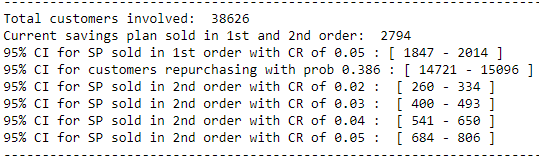

The positive thing is that we have now a bigger base of potential new customers facing the 5% upgrading topic (in case of course they buy our SP). The disadvantage would be if a lot of customers refuse to buy the SP 1st version because of the low discount provided.
    + A/B testing
    + 1st roll-out in a small site and analyse performance 1 month before/after deployment

Consider that, if EC eligibility stays as it actually is...customers can go through the high discount tiers if they match our threshold criteria -in case they don´t want to buy SP in 1st-2nd order-.

In [93]:
#Describing basket values distribution per tier
orders.groupby('CZP_ZTQ_ID')['SCM_SALES_BMF_sum'].describe()

,count,mean,std,min,25%,50%,75%,max
CZP_ZTQ_ID,,,,,,,,
0,49393.0,60.118256,39.557659,-12.03,37.7800,49.91,69.99,1899.99
55,832.0,72.421467,35.996998,-1.83,45.4175,64.68,88.21,235.20
56,3302.0,90.329101,69.861468,-5.42,52.9850,73.39,110.12,2390.62


Looking at the data, customers having higher basket values tend to buy SP (makes sense because, in case of the same purchasing frquency they would be able to pay it off earlier). However, as SP offer is displayed in checkout, the customer has already make a predisposition to accomplish the payment, so that we cannot link the tier 56 disappearing from the offer with a decrease in basket values.